In [1]:
import sys  
sys.path.insert(0, './codes')
from numpy import pi,e,cos,sin,tan,linspace,sqrt,array,shape,reshape
from pade_func import pade_analytic_continuation


#### NOTE: hbar and k_B are equal to 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#import holoviews as hv
#import pandas as pd
#import xarray as xr

In [3]:
def density_of_states_behte_non_int (omega, D):
    '''
    density of states of a Bethe lattice with infinite connectivity 
    (from the analytical expression of the non interacting GF)

    input:      omega       real frequency/energy 
                D           bandwidth, the density of states is non zero for |omega|<D

    output:     rho(omega)  densiy of states, rho(w)=2*sqrt(D^2-w^2)/pi*D^2
    '''

    return np.sqrt(4*D**2-omega**2)/(2*np.pi*D**2)



beta=2
omega_n=np.pi/beta*(2*np.array(range(-0,150))+1)
dos_bethe=density_of_states_behte_non_int(1j*omega_n,2)
#Gloc_bethe=get_Gloc(dos_bethe,1j*omega_n,eps,0)

In [5]:
def f(e,beta):
    return 1/(1+np.exp(beta*e))
def GF_tau(tau, ek, beta):
    return -np.exp(-ek*tau) * ( (1-f(ek,beta))*np.heaviside(tau,1) - f(ek,beta)*np.heaviside(-tau,1) )

## Checking if Fourier transform is correct

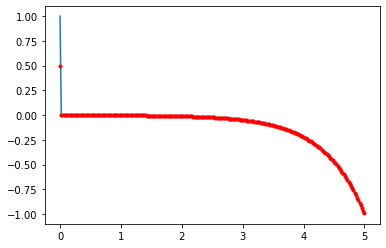

In [8]:
beta=5
N_iomega=100
nn=np.concatenate((np.array(range(-N_iomega//2,0)),np.array(range(0,N_iomega//2))),axis=None)
omega_n=np.pi/beta*(2*nn+1)
ek=-1.5
tau=linspace(-beta,-1e-10,500)
Gtau=GF_tau(tau, ek, beta)
#plt.plot(tau,Gtau)

tau=linspace(0,beta,250)
Gtau=GF_tau(tau, ek, beta)
plt.plot(tau,Gtau)


G0=(1j*omega_n-ek)**(-1)
Gtau_num=fourier_trans_to_imag_time(G0,tau,omega_n)
plt.plot(tau,Gtau_num,'r.')

# Functions
## Fourier Transforms and Solver

In [7]:
#N_cutoff = 500
##### TODO:  CHECK THE CUTOFF FOR EVALUATING THE SUM IN THE FOURIER TRANSFORM  ############

def fourier_trans_to_imag_time(G_iw, tau, omega_n):
    '''
    Fourier transform of a function G(i*omega_n) where i*omega_n are Matzubara frequencies
    (needed to perform the Iterative Perturbation Theory Step)
    
    input:      func        G(i*omega_n): function of i*omega (Matzubara frequencies)
                beta        inverse temperature
                tau         imaginary time        

    output:     G(tau)      function of the imaginary time (tau), G(tau)=(1/beta)* sum_(w_n)  (e^i*w_n*tau)*G(i*omega_n)
    '''
    
    #nn = np.linspace(start=0, stop=N_iomega, num=N_iomega, dtype=int)
    #matz_frequencies = np.pi*(1/beta) * (2*nn + 1)
    #domega=(matz_frequencies[-1]-matz_frequencies[0])/beta
    
    G_iw_prime = G_iw - 1/(1j*omega_n)
    exponential_iw = np.exp(np.inner(-1j*omega_n[:,np.newaxis],tau[:,np.newaxis]))
    
    G_iw_prime=G_iw_prime[len(omega_n)//2:]
    exponential_iw = exponential_iw[len(omega_n)//2:]
    intg1=np.real(exponential_iw*G_iw_prime[:,np.newaxis]) 
    
    #intg2=
    
    ans1=np.sum(intg1,axis=0)*2/beta

    return  ans1 - np.sign(tau)/2

def inv_fourier_trans_to_omega(G_tau, tau, omega_n,dt=1e-3):
    '''
    Inverse Furier transform of a function G(tau) to G(iwn) where iwn are Matzubara frequencies
    (needed to perform the Iterative Perturbation Theory Step)
    
    input:      func        G(i*omega_n): function of i*omega (Matzubara frequencies)
                beta        inverse temperature
                tau         imaginary time        

    output:     G(iwn)      function of the matsubara frequencies
    '''
    exponential_tau = np.exp(np.inner(tau[:,np.newaxis],1j*omega_n[:,np.newaxis]))

    return  np.sum(exponential_tau * G_tau[:,np.newaxis],axis=0) * (tau[-1]-tau[0])/len(tau)

In [9]:
########### TODO: find limits of integration for the integral in time!!!  
#time_integral_steps=1000

def IPT_solver(G0, omega_n, U, beta,dt=1e-4):
    '''
    finds the self energy of the auxiliary Anderson impurtity model Sigma_imp
    from this it evaluates also the interacting Green's function of the auxiliary system (G coursive)

    input:      impurity_non_int_greens_func        G_0 (iomega) coursive: non interacting Green's function of the auxiliary system
                                                                           encoded in step (3) and evaluated on Matzubara frequency
                iomega                              Matzubara frequency i*omega_n
                U                                   impurity interaction
                beta                                inverse temperature  

    output:     impurity_self_energy(iomega)        self energy of the auxiliary system    Sigma_imp(iw)=U/2 + U^2 * int_0^beta d(tau) (e^i*w_n*tau) * G_0^shifted(tau)^3
                                                                                           knowing G_0^shifted(iw)= (G_0(iw)^-1  - U/2)^-1     where all the G are coursive
                impurity_int_greens_func(iomega)    interacting GF of the auxiliary system   G(iw) = (  G_0(iw)^-1 - Sigma_imp(iw)  )^-1          where all the G are coursive

    note: this fucntion uses the function fourier_trans_to_imag_time() to convert G_0^shifted(iw) coursive in imaginary time
    '''

    # I calculate G_0_shifted(iw) as a function of iomega
    G0_shifted = 1 / ( (1/G0) - U/2 )

    # I calculate the fourier transform G_0_shifted(tau)
    tau=np.arange(0.00001,beta,dt)
    #tau = np.linspace(start=1e-10, stop=beta+1e-10, num=time_integral_steps)
    G0_tau_shifted_ = fourier_trans_to_imag_time(G0_shifted, tau, omega_n)

    # I calculate the integral
    G0_tau_cube=G0_tau_shifted_**3
    integral = inv_fourier_trans_to_omega(G0_tau_cube, tau, omega_n,dt)
    

    # I get Sigma_imp and the interacting GF of the impurity
    Sigma_imp = U/2 + U**2  * integral

    #G_0_iw = impurity_non_int_greens_func
    G_imp = 1 / ( 1/G0 - Sigma_imp )
    return Sigma_imp, G_imp

## DMFT cycle

In [10]:
def dos_cubic(arg,t):
    """ WORK IN PROGRESS """
    from scipy.special import ellipk
    N=25
    kx=-np.linspace(-pi,pi,N)
    ky=-np.linspace(-pi,pi,N)
    kz=-np.linspace(-pi,pi,N)
    
    Gloc=np.zeros(len(arg))+0*1j
    for ix in range(len(kx)):
        for iy in range(len(ky)):
            for iz in range(len(kz)):
                ek=-2*t*(cos(kx[ix])+cos(ky[iy])+cos(kz[iz]))
                Gloc +=1/(arg-ek)/(N**3)
    
    return -Gloc.imag/pi

def get_Gloc(omega_n,eps,sigma_imp,mu,D):
    '''
    get local interacting green's function
    input:    rho           vector with density of states evaluated at all the energy steps of the integral
              omega_n       vector with matzubara frequencies form O to N_matz_freq
              eps           values of energies of the integration = eps=np.linspace(-D,D,len(omega_n))
    '''
    #sigma_imp=0.
    rho=density_of_states_behte_non_int(eps,D)
    Gloc=np.zeros(len(omega_n))+0*1j
    d_eps=(eps[-1]-eps[0])/len(eps)

    for i in range(len(eps)):
        Gloc += rho[i]/(1j*omega_n+mu-eps[i]-sigma_imp)*d_eps
    return Gloc

/Users/muhammedxgunes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


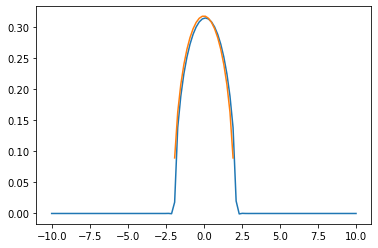

In [32]:
#eps=np.linspace(-1.999*D,1.999*D,len(omega_n))
nn=np.concatenate((np.array(range(-N_iomega//2,0)),np.array(range(0,N_iomega//2))),axis=None)
#nn=np.array(range(0,N_iomega))
omega_n=np.pi/beta*(2*nn+1)
G_loc=get_Gloc(omega_n,eps,0,mu,D)
GF = pade_analytic_continuation(wnn=omega_n,nw_out=len(energy), emin=emin, emax=emax, gff=G_loc)[0]
plt.plot(energy, -GF.imag/np.pi)
plt.plot(energy, density_of_states_behte_non_int(energy,1))

# $G(\tau)$ from non interacting Green's function. It gives information about the gap and the filling.

Text(0.5, 0, '$\\tau/\\beta$')

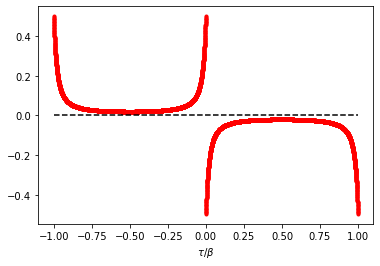

In [30]:
beta=50
tau=np.arange(-beta,beta,1e-2)
mu=0
nn=np.concatenate((np.array(range(-N_iomega//2,0)),np.array(range(0,N_iomega//2))),axis=None)
#nn=np.array(range(0,N_iomega))
omega_n=np.pi/beta*(2*nn+1)
G_loc=get_Gloc(omega_n,eps,0,mu,D)
#plt.plot(omega_n,G_loc.imag)
Gtau=fourier_trans_to_imag_time(G_loc, tau, omega_n)
plt.plot(tau/beta,Gtau,'r.')
plt.plot(np.linspace(-1,1,100),np.zeros(100),'k--')
plt.xlabel(r'$\tau/\beta$')

In [35]:
#### T=0.03
#1/T
D = 1

epsylon = 1e-10
emin=-10
emax=10
energy=np.linspace(emin,emax,100)
mu=0
# ---> define the energies where to integrate:
#nn=np.linspace(start%store(N_iomega-1)/2, stop=(N_iomega-1)/2, num=N_iomega, dtype=int); omega_n=np.pi/beta*(2*nn+1)

eps=np.linspace(-2*D,2*D,len(omega_n))
#rho=1/sqrt(4.000001*D**2-eps**2)/pi
#rho = density_of_states_behte_non_int(eps,D)

#N_iter_max = 200
# step 1: set Sigma_loc

#Sigma_loc = -1/(1j*omega_n)

Gloc_list = []
Gimp0_list = []
Gimp_list = []
sigma_list = []


every step after the IPT, choose mu so that G_loc_new gives the value of filling

In [37]:
N_iomega=200
U = 1 *4/sqrt(2)
beta=50

nn=np.concatenate((np.array(range(-N_iomega//2,0)),np.array(range(0,N_iomega//2))),axis=None)
#nn=np.array(range(0,N_iomega))
omega_n=np.pi/beta*(2*nn+1)


Sigma_loc = np.zeros(N_iomega)+0*1j
Sigma_imp = np.zeros(N_iomega)
dist=.1
c=0
#for n_iter in range(N_iter_max):
while dist>epsylon:
    """dt and N_iomega must be adjusted adaptively"""
    
    # step 2: get local GF
    G_loc=get_Gloc(omega_n,eps,Sigma_loc,mu,D)
    Gloc_list.append(G_loc)
    #plt.plot(omega_n,-np.imag(G_loc))
    # step 3: obtain the impurity GF
    G0= 1/( (1/G_loc) + Sigma_loc )
    Gimp0_list.append(G0)

    # step 4: solve impurity model
    Sigma_imp, G_imp = IPT_solver(G0,omega_n,U,beta,dt=5e-3)
    Gimp_list.append(G_imp)
    sigma_list.append(Sigma_imp)
    G_loc_new=get_Gloc(omega_n,eps,Sigma_imp,mu,D)
    
    #G0_new=1/( (1/G_imp) + Sigma_imp )
    # step 5:
    if np.mod(c,5)==0:
        #print(np.sum(Sigma_loc))
        #print(G_loc[0])
        print('I completed iteration number', c, 'distance',dist)
        dist=np.abs(np.sum(Sigma_loc - Sigma_imp))
        alpha=1
        Sigma_loc = alpha*Sigma_imp+(1-alpha)*Sigma_loc
        mu=(Sigma_imp[-1]).real
        
    c += 1
        #G_loc=G_imp
        
print('I reached convergence!', )


I completed iteration number 0 distance 0.1
I completed iteration number 5 distance 237.65981680014823
I completed iteration number 10 distance 14.9654682034997
I completed iteration number 15 distance 8.702841488905804
I completed iteration number 20 distance 6.1281904177623705
I completed iteration number 25 distance 4.288982759403842
I completed iteration number 30 distance 2.923088904110947
I completed iteration number 35 distance 1.9573013225802325
I completed iteration number 40 distance 1.2984595552189107
I completed iteration number 45 distance 0.8574737926908407
I completed iteration number 50 distance 0.5650182678852551
I completed iteration number 55 distance 0.3719141903276211
I completed iteration number 60 distance 0.2446758161501439
I completed iteration number 65 distance 0.16092493304639222
I completed iteration number 70 distance 0.10582643506151301
I completed iteration number 75 distance 0.06958729374897255
I completed iteration number 80 distance 0.0457556503545455

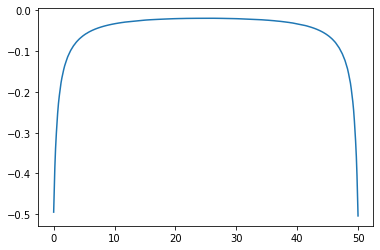

In [38]:
#This is G(tau). its value at tau=beta gives the filling (with minus sign). For our initial case, 
#both ends of G(tau) should be -0.5. If it's tilting, it is not half filled.

tau=np.arange(0.001,beta,1e-3)
Gtau=fourier_trans_to_imag_time(G_loc_new, tau, omega_n)
plt.plot(tau,Gtau)

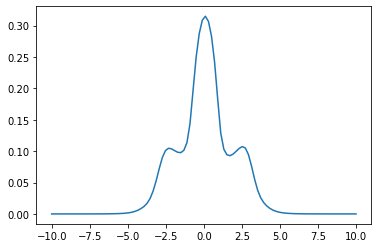

In [39]:
#Spectrum

from pade_func import pade_analytic_continuation
#local interacting
GF = pade_analytic_continuation(wnn=omega_n,nw_out=len(energy), emin=emin, emax=emax, gff=G_loc_new)[0]
plt.plot(energy, -GF.imag/np.pi)


1.414213562373095

In [44]:
#check sigma as omega --> infinity (it should be U/2 for half filling)
print(Sigma_imp[-1].real,U/2)

1.4083498484723547 1.414213562373095


# Check the Metalic vs Insulating State
## This information is given by the imaginary part of $\Sigma(i\omega_n)$. If it is zero at $\omega_n=0$, it is metallic, if it is diverging then it is insulator.

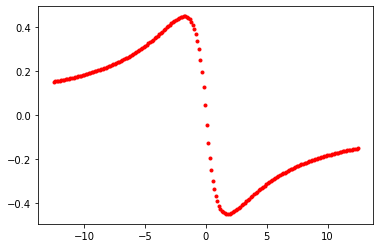

In [45]:
#plt.plot(omega_n,sigma_list[0].imag)
plt.plot(omega_n,Sigma_imp.imag,'r.')
#plt.ylim(0,1)

After this point is chaotic scripts that I did not finalize lol

In [ ]:
## plts = []
df = pd.DataFrame( data={'n_iter':          range(N_iter_max),
                         'energy':          energy 
                        '-Gloc.imag/pi':   (-np.array(Gloc_list).imag/np.pi).flatten(), 
                        '-Gimp_0.imag/pi': (-np.array(Gimp0_list).imag/np.pi).flatten(),
                        '-Gimp.imag/pi':   (-np.array(Gimp0_list).imag/np.pi).flatten()})

df = df.set_index(['n_iter'])
ds=xr.Dataset.from_dataframe(df)
            
plts.append(hv.Dataset(ds['-Gloc.imag/pi']).to(hv.Curve,
                groupby=['n_iter'],dynamic=True).opts(ylim=(-0.2,1),tools=['hover','yzoom_in']))
        
hv.Layout([plt.opts(tools=['hover','yzoom_in'],height=400,width=400) for plt in plts]).cols(2)

## Test of analytic continuation for the Bethe lattice 

In [ ]:
beta=20
D = 1
N_iomega=500
U = 1
epsylon = 0.01

nn = np.linspace(start=0, stop=N_iomega-1, num=N_iomega, dtype=int)
iomega = 1j*np.pi/beta*(2*np.array(range(0,N_iomega))+1)

N_energy = 1000
emin = -2.0
emax = 2.0
energy = np.linspace(emin, emax, N_energy)
rho_1d=1/sqrt(4.00001*D**2-energy**2)/pi

# analytic formula non int gf bethe
gf_non_int=2/(D**2) * (energy - np.sqrt(energy**2-D**2, dtype=complex))
#plt.plot(energy, -gf_non_int.imag/np.pi)

# analytic formula of the density
#plt.plot(energy, density_of_states_behte_non_int(energy,D),'-')
plt.plot(energy, rho_1d,'-')

Gloc=get_Gloc(rho_1d,iomega,energy,0)
# gf on matzubara freq
gf_non_int_matz=Gloc#2/(D**2) * (iomega - np.sqrt(iomega**2-D**2, dtype=complex))
gf_non_int_real_freq = pade_analytic_continuation(wn=iomega.imag, nw=N_iomega, nw_out=N_energy, emin=-2, emax=2, gf=gf_non_int_matz.reshape((1,N_iomega)))[0]

plt.plot(energy, -gf_non_int_real_freq.imag/np.pi,'r-.')
plt.ylim(0,10)

In [ ]:
from scipy.special import ellipkm1
dphi=1e-2
t=1
phi=-np.arange(-pi,pi,dphi)
dos=np.zeros(len(eps))

for i in range(len(phi)):
    dos += 1/(4*pi**3*t)* np.sum(ellipkm1(    sqrt(1-((eps+2*t*cos(phi[i])))/(4*t) )   ))

plt.plot(eps,dos)

ModuleNotFoundError: No module named 'gftool'

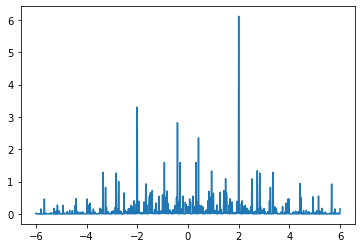

In [33]:
mu=0
eps=np.linspace(-6,6,1000)
dos=dos_cubic(eps + 1j*0.001,1)
plt.plot(eps,dos)
import gftool as gt

eps = np.linspace(-1.2, 1.2, num=6001)
dos = gt.sc_dos(eps, half_bandwidth=1)

In [ ]:
        
        plts = []

        df = pd.DataFrame( data={'Freq(GHz)':     data.freq,
                                 'Magn_curr(A)':  data.field, 
                                 'Modulus(dB)':   20*np.log10(np.abs(data.derivative)),
                                 'Phase(rad)':    np.angle(data.derivative)
                                 })

        df = df.set_index(['Freq(GHz)', 'Magn_curr(A)'])
        ds=xr.Dataset.from_dataframe(df)
        
        plts.append(hv.Dataset(ds['Modulus(dB)']).to(hv.Curve,
                       groupby=['Freq(GHz)'],dynamic=True).opts(ylim=(-120.0,10.0),tools=['hover','yzoom_in']))
        plts.append(hv.Dataset(ds['Phase(rad)']).to(hv.Curve,
                       groupby=['Freq(GHz)'],dynamic=True).opts(ylim=(-np.pi,np.pi),tools=['hover','yzoom_in']))
        
        return hv.Layout([plt.opts(tools=['hover','yzoom_in'],height=400,width=400) for plt in plts]).cols(2)